# Batch Document Extraction with InternVL3.5-8B (H200 + bfloat16)

**H200 REFERENCE VERSION**: This notebook uses bfloat16 precision to establish baseline performance on modern GPU architecture.

This notebook is designed to run on H200 GPU with native bfloat16 support for comparison with V100 float32 performance.

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Comparison Purpose**:
- **H200 + bfloat16**: Native hardware support, optimal performance (this notebook)
- **V100 + float32**: No bfloat16 support, requires full precision (ivl3_8b_batch.ipynb)

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- H200/H100/A100 GPU (with native bfloat16 support)

**Key Features**:
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Flash Attention 2 enabled (H200 optimized)
- Improved performance over InternVL3 series

This notebook includes steps for:
* Loading documents
* Detecting document types  
* Extracting relevant information
* Generating reports
* **Comparing accuracy vs V100 to understand hardware impact**

## 1. Imports

In [1]:
#Cell 1
# Path setup for V100 systems - ensures proper module resolution
import sys
import os
from pathlib import Path
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'


# Get the notebook's directory
notebook_path = Path().absolute()
print(f"📂 Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"✅ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace

    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/ground_truth.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # ============================================================================
    # H200 BFLOAT16 CONFIGURATION - OPTIMAL PERFORMANCE BASELINE
    # ============================================================================
    # This configuration uses H200's native bfloat16 support for optimal performance.
    # Compare against V100 float32 to understand hardware limitations impact.
    #
    # H200 advantages:
    # - Native bfloat16 hardware support (compute capability 9.0)
    # - Flash Attention 2 support for faster inference
    # - Higher memory bandwidth and capacity
    #
    # Configuration:
    # - bfloat16: Native hardware support, no conversion needed
    # - Flash Attention: Enabled for faster processing
    # - No quantization: Full precision for accuracy baseline
    # ============================================================================
    'USE_QUANTIZATION': False,  # Full precision for H200
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 1000,
    'TORCH_DTYPE': 'bfloat16',  # Native H200 support
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: ENABLED for H200/H100/A100
    'USE_FLASH_ATTN': True,  # H200 optimized - faster inference
    
    # H200 TILE CONFIGURATION
    'MAX_TILES': 16,  # H200 optimized - InternVL3.5 training max for dense OCR
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
}

# Import field filtering from config to exclude validation-only fields
from common.config import get_v4_field_list, filter_evaluation_fields

# Get universal field list and filter out validation-only fields
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = filter_evaluation_fields(get_v4_field_list())

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)")
print(f"⚡ Flash Attention: {'ENABLED (H200 optimized)' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (InternVL3.5 training max for dense OCR)")
print("🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution")
print("📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data
📊 Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv
🤖 Model: InternVL3.5-8B
📁 Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
📁 Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
📋 Universal fields: 14 (validation-only fields excluded)
🎯 Mode: Evaluation mode
⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)
⚡ Flash Attention: ENABLED (H200 optimized)
🔲 Max Tiles: 16 (InternVL3.5 training max for dense OCR)
🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution
📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [6]:
#Cell 6
# Load InternVL3.5 model using official pattern with multi-GPU split_model() fix
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
# Multi-GPU fix: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html
import math
from transformers import AutoConfig

rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

def split_model(model_path):
    """
    Official InternVL3 multi-GPU device mapping function.
    
    Creates a custom device map that ensures the first and last layers of the
    language model stay on the same device (GPU 0) to prevent tensor placement
    mismatches during generation.
    
    From: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html
    """
    device_map = {}
    world_size = torch.cuda.device_count()
    config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
    num_layers = config.llm_config.num_hidden_layers
    
    # Since the first GPU will be used for ViT, treat it as half a GPU
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for _j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    
    # Critical components must stay on GPU 0
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    
    # CRITICAL: Force last layer back to GPU 0 to prevent device mismatch
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0
    
    return device_map

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    # Determine device map based on GPU count
    world_size = torch.cuda.device_count()
    rprint(f"[cyan]🖥️  Detected {world_size} GPU(s)[/cyan]")
    
    if world_size > 1:
        # Multi-GPU: Use official split_model() function
        rprint("[cyan]📥 Loading model with official multi-GPU split_model() pattern...[/cyan]")
        device_map = split_model(CONFIG['MODEL_PATH'])
        rprint(f"[blue]🔄 Custom device map created with {len(device_map)} entries[/blue]")
        rprint("[blue]✅ First and last LLM layers anchored to GPU 0 (prevents device mismatch)[/blue]")
    else:
        # Single GPU: Use simple device map
        rprint("[cyan]📥 Loading model on single GPU...[/cyan]")
        device_map = {"": 0}
    
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
        device_map=device_map
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # BEAUTIFUL MULTI-GPU MEMORY DISPLAY (matching llama_batch.ipynb)
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            # Multi-GPU detailed breakdown
            rprint(f"[blue]🔄 Multi-GPU Distribution Analysis ({device_count} GPUs):[/blue]")
            
            total_allocated = 0
            total_reserved = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_reserved = torch.cuda.memory_reserved(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_reserved += gpu_reserved
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total across all GPUs: {total_allocated:.1f}GB allocated, {total_reserved:.1f}GB reserved, {total_capacity:.0f}GB capacity[/blue]")
            
            if hasattr(model, 'hf_device_map'):
                from collections import Counter
                device_distribution = Counter(model.hf_device_map.values())
                rprint(f"[green]✅ Model successfully distributed: {dict(device_distribution)}[/green]")
        else:
            # Single GPU
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # BEAUTIFUL CONFIGURATION TABLE (matching llama_batch.ipynb)
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    # Model path
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    
    # Model type
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    
    # Device placement
    config_table.add_row("Device Placement", str(next(model.parameters()).device), "✅ Loaded")
    
    # Quantization
    quant_status = "✅ 16-bit (Performance Optimized)" if not CONFIG['USE_QUANTIZATION'] else "✅ 8-bit (Memory Optimized)"
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, quant_status)
    
    # Data type
    config_table.add_row("Data Type", str(CONFIG['TORCH_DTYPE']), "✅ Recommended")
    
    # Max new tokens
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    
    # Max tiles
    config_table.add_row("Max Tiles", str(CONFIG['MAX_TILES']), "✅ H200 Optimized")
    
    # GPU configuration
    if torch.cuda.is_available():
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB)"
            gpu_status = f"✅ {total_capacity:.0f}GB Total"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    # Model parameters
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    # Flash Attention
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,
        max_tiles=CONFIG['MAX_TILES']  # H200 optimized tile configuration
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint("[cyan]🎯 Enhanced with Cascade RL for improved reasoning[/cyan]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles for dense OCR[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

Loading InternVL3.5-8B model...

🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)

📖 Features: Cascade RL, Visual Resolution Router (ViR)

🧹 CUDA cache cleared

🖥️  Detected 2 GPU(s)

📥 Loading model with official multi-GPU split_model() pattern...

🔄 Custom device map created with 44 entries

✅ First and last LLM layers anchored to GPU 0 (prevents device mismatch)

`torch_dtype` is deprecated! Use `dtype` instead!


FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

🔄 Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA L40S): 8.2GB/48GB (17.1%)

GPU 1 (NVIDIA L40S): 8.9GB/48GB (18.6%)

📊 Total across all GPUs: 17.1GB allocated, 17.1GB reserved, 96GB capacity

✅ Model successfully distributed: {0: 21, 1: 23}

                       🔧 InternVL3.5-8B Model Configuration                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                 ┃ Status                            ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ InternVL3_5-8B        │ ✅ Valid                          │
│ Model Type          │ InternVL3.5-8B        │ ✅ Cascade RL + ViR               │
│ Device Placement    │ cuda:0                │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16              │ ✅ Recommended                    │
│ Max New Tokens      │ 1000                  │ ✅ Generation Ready               │
│ Max Tiles           │ 16                    │ ✅ H200 Optimized                 │
│ GPU Configuration   │ 2x NVIDIA L40S (96GB) │ ✅ 96GB Total                     │
│ Model Parameters    │ 8,528,318,464         │ ✅ Loaded                         │
│ Flash Attention     │ True                  │ ✅ Enabled                        │
└─────────────────────┴───────────────────────┴───────────────────────────────────┘

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 14 fields: DOCUMENT_TYPE → TOTAL_AMOUNT
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=15.89GB, Reserved=15.93GB
🤖 Auto-detected batch size: 8 (GPU Memory: 73.1GB)
🎯 DOCUMENT AWARE REDUCTION: 14 fields (~52% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 8,528,318,464
🚀 V100 optimizations applied


✅ InternVL3.5-8B ready for document-aware processing

🎯 Enhanced with Cascade RL for improved reasoning

🔲 Using 16 tiles for dense OCR

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 19 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 19 images


✅ Ground truth loaded for 19 images

Ready to process 20 images

Data directory: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_date_grouped.png
  3. cba_date_grouped_cont.png
  4. cba_debit_credit.png
  5. cba_highligted.png
  ... and 15 more


## 8. Batch Processing

In [8]:
#Cell 8
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 19 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 19 images


✅ Loaded ground truth for 19 images

📋 Sample GT keys: ['cba_date_grouped.png', 'cba_date_grouped_cont.png', 'transaction_summary.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/20]: cba_amount_balance.png

🔍 TRACE: Processing InternVL3 image 1/20: cba_amount_balance.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_amount_balance.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📝 Using bank_statement_flat prompt (prompt_config): 331 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_amount_balance.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_flat'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

📝 Loading bank_statement_flat prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (331 chars):

================================================================================

Extract information from this Bank Statement document.

OUTPUT FORMAT (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
TRANSACTION_DATES: [Dates with " | "]
LINE_ITEM_DESCRIPTIONS: [Descriptions with " | "]
TRANSACTION_AMOUNTS_PAID: [Debits with $ and " | "]
STATEMENT_DATE_RANGE: [Earliest Date Column Value - Latest Date Column Value]

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (833 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENT
TRANSACTION_DATES: 03 Jun 2023 | 04 Jun 2023 | 06 Jun 2023 | 06 Jun 2023 | 07 Jun 2023 | 08 Jun 2023 | 08 Jun 2023 
| 09 Jun 2023 | 09 Jun 2023 | 10 Jun 2023 | 12 Jun 2023 | 14 Jun 2023
LINE_ITEM_DESCRIPTIONS: GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL T 
54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB 
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AU AUS
TRANSACTION_AMOUNTS_PAID: $78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00 | $145.50 | 
$567.30 | $42.85 | $234.90
STATEMENT_DATE_RANGE: 03 Jun 2023 - 14 Jun 2023

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '03 Jun 2023 - 14 Jun 2023' -> '03 Jun 2023-14 Jun 2023'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS |
CAFE CENTRAL T 54321F SUBURB...' -> 'GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE 
CENTRAL T 54321F SUBURB...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 
| 08/06/2023 | 09/06/202...' -> '03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 | 
08/06/2023 | 09/06/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | 
$89.00 | $145.50 | $567.30 | $42.85 ...' -> '$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00
| $145.50 | $567.30 | $42.85 ...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "03 Jun 2023-14 Jun 2023"

✅ LINE_ITEM_DESCRIPTIONS: "GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL 
T 54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AU AUS"

✅ TRANSACTION_DATES: "03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 | 08/06/2023 |
09/06/2023 | 09/06/2023 | 10/06/2023 | 12/06/2023 | 14/06/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00 | $145.50 | 
$567.30 | $42.85 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_amount_balance.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from cba_amount_balance.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 80.0% for cba_amount_balance.png

  Precision: 80.0% | Recall: 80.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [2/20]: cba_date_grouped.png

🔍 TRACE: Processing InternVL3 image 2/20: cba_date_grouped.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (627 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "15/03/2024 to 14/04/2024",
  "LINE_ITEM_DESCRIPTIONS": "TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | SHELL SERVICE
STATION RICHMOND VIC | NETFLIX SUBSCRIPTION | COLES SUPERMARKET CARLTON VIC | PARKING METERS MELBOURNE VIC | RENT 
PAYMENT REAL ESTATE | CHEMIST WAREHOUSE MELBOURNE VIC",
  "TRANSACTION_DATES": "18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 05/04/2024 | 08/04/2024 | 10/04/2024 | 
14/04/2024",
  "TRANSACTION_AMOUNTS_PAID": "$48.50 | $127.35 | $89.60 | $22.99 | $156.78 | $15.00 | $1,850.00 | $54.64"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '15/03/2024 to 14/04/2024' -> '15/03/2024 to 14/04/2024'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS 
| SHELL SERVICE STATION RICHM...' -> 'TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | 
SHELL SERVICE STATION RICHM...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 05/04/2024 | 08/04/2024 
| 10/04/2024 | 14/04/202...' -> '18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 05/04/2024 | 08/04/2024 | 
10/04/2024 | 14/04/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$48.50 | $127.35 | $89.60 | $22.99 | $156.78 | $15.00 | $1,850.00 | 
$54.64' -> '$48.50 | $127.35 | $89.60 | $22.99 | $156.78 | $15.00 | $1,850.00 | $54.64'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "15/03/2024 to 14/04/2024"

✅ LINE_ITEM_DESCRIPTIONS: "TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | SHELL 
SERVICE STATION RICHMOND VIC | NETFLIX SUBSCRIPTION | COLES SUPERMARKET CARLTON VIC | PARKING METERS MELBOURNE VIC 
| RENT PAYMENT REAL ESTATE | CHEMIST WAREHOUSE MELBOURNE VIC"

✅ TRANSACTION_DATES: "18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 05/04/2024 | 08/04/2024 | 10/04/2024 |
14/04/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$48.50 | $127.35 | $89.60 | $22.99 | $156.78 | $15.00 | $1,850.00 | $54.64"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.65GB allocated, 7.68GB reserved

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from cba_date_grouped.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 48.2% for cba_date_grouped.png

  Precision: 80.0% | Recall: 38.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [3/20]: cba_date_grouped_cont.png

🔍 TRACE: Processing InternVL3 image 3/20: cba_date_grouped_cont.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped_cont.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped_cont.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (851 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM MEMBERSHIP 
FITNESS FIRST VIC AU A | AUTO SERVICES BRUNSWICK AU AUS | HARDWARE STORE BUNNINGS VIC AU | ELECTRONICS STORE JB HI 
FI AU AUS | PHARMACY CHEMIST MELBOURNE VIC | DIRECT DEBIT INSURANCE PREMIUM | STREAMING SERVICE SPOTIFY AUS | PET 
SUPPLIES PETBARN RICHMOND VIC | UTILITIES ELECTRICITY BILL | DEPARTMENT STORE MYERS VIC AU",
  "TRANSACTION_DATES": "16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 08/05/2024 | 
10/05/2024 | 14/05/2024 | 16/05/2024 | 22/05/2024 | 26/05/2024",
  "TRANSACTION_AMOUNTS_PAID": "$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50 | $14.99 |
$98.75 | $178.60 | $234.90"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | 
GYM MEMBERSHIP FITNESS FIRST V...' -> 'RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM 
MEMBERSHIP FITNESS FIRST V...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 
| 08/05/2024 | 10/05/202...' -> '16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 
08/05/2024 | 10/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | 
$85.50 | $14.99 | $98.75 | $178.6...' -> '$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50
| $14.99 | $98.75 | $178.6...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM MEMBERSHIP 
FITNESS FIRST VIC AU A | AUTO SERVICES BRUNSWICK AU AUS | HARDWARE STORE BUNNINGS VIC AU | ELECTRONICS STORE JB HI 
FI AU AUS | PHARMACY CHEMIST MELBOURNE VIC | DIRECT DEBIT INSURANCE PREMIUM | STREAMING SERVICE SPOTIFY AUS | PET 
SUPPLIES PETBARN RICHMOND VIC | UTILITIES ELECTRICITY BILL | DEPARTMENT STORE MYERS VIC AU"

✅ TRANSACTION_DATES: "16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 08/05/2024 |
10/05/2024 | 14/05/2024 | 16/05/2024 | 22/05/2024 | 26/05/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50 | $14.99 
| $98.75 | $178.60 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped_cont.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from cba_date_grouped_cont.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 37.8% for cba_date_grouped_cont.png

  Precision: 80.0% | Recall: 30.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [4/20]: cba_debit_credit.png

🔍 TRACE: Processing InternVL3 image 4/20: cba_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (955 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING SUBURB 
AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer to financially sorted 
| GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY LTD 
SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD 
Suburb VICAU | Afterpay afterpay.com AU AUS
TRANSACTION_DATES: 20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 
22/05/2024 | 22/05/2024 | 22/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 24/05/2024
TRANSACTION_AMOUNTS_PAID: $178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | $124.00 | $78.90 | 
$56.40 | $1,456.80 | $67.75 | $89.25 | $45.80 | $234.90
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | 
SUPERMARKET SHOPPING SUBURB AU | SHOPP...' -> 'Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | 
SUPERMARKET SHOPPING SUBURB AU | SHOPP...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 
| 21/05/2024 | 22/05/202...' -> '20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 
21/05/2024 | 22/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | 
$124.00 | $78.90 | $56.40 | $1,45...' -> '$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | 
$124.00 | $78.90 | $56.40 | $1,45...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING 
SUBURB AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer to financially 
sorted | GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY 
LTD SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD
Suburb VICAU | Afterpay afterpay.com AU AUS"

✅ TRANSACTION_DATES: "20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 |
22/05/2024 | 22/05/2024 | 22/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 24/05/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | $124.00 | $78.90
| $56.40 | $1,456.80 | $67.75 | $89.25 | $45.80 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_debit_credit.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from cba_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 75.3% for cba_debit_credit.png

  Precision: 80.0% | Recall: 71.2%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [5/20]: cba_highligted.png

🔍 TRACE: Processing InternVL3 image 5/20: cba_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([17, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (330 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
  "TRANSACTION_DATES": "23/03/2024 | 24/03/2024 | 27/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024",
  "TRANSACTION_AMOUNTS_PAID": "$2,145.80 | $850.00 | $325.45 | $178.90 | $1,285.65 | $4,200.00"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: TRANSACTION_DATES: '23/03/2024 | 24/03/2024 | 27/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024'
-> '23/03/2024 | 24/03/2024 | 27/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$2,145.80 | $850.00 | $325.45 | $178.90 | $1,285.65 | $4,200.00' -> 
'$2,145.80 | $850.00 | $325.45 | $178.90 | $1,285.65 | $4,200.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

✅ TRANSACTION_DATES: "23/03/2024 | 24/03/2024 | 27/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$2,145.80 | $850.00 | $325.45 | $178.90 | $1,285.65 | $4,200.00"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 3/7 fields

Found: ['DOCUMENT_TYPE', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID']

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.65GB allocated, 7.68GB reserved

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 3/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_highligted.png, doc_type=BANK_STATEMENT

✓ Extracted 3 fields from cba_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 20.0% for cba_highligted.png

  Precision: 20.0% | Recall: 20.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[5/20] cba_highligted.png: BANK_STATEMENT - Accuracy: 20.0% - Time: 23.47s

Processing [6/20]: cba_home_loan.png

🔍 TRACE: Processing InternVL3 image 6/20: cba_home_loan.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_home_loan.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_home_loan.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (567 chars):

================================================================================

Here's the structured data extracted from the bank statement:

**DOCUMENT_TYPE:** BANK_STATEMENT

**STATEMENT_DATE_RANGE:** 01 Jul 2025 to 16 Nov 2025

**LINE_ITEM_DESCRIPTIONS:** Repayment/Payment NetBank | Repayment/Payment NetBank | Repayment Redraw NetBank | 
Interest charged | Repayment/Payment | Reversal of a transaction made 13/11/25 | Interest charged

**TRANSACTION_DATES:** 27/10/2025 | 27/10/2025 | 27/10/2025 | 02/11/2025 | 04/11/2025 | 13/11/2025 | 13/11/2025

**TRANSACTION_AMOUNTS_PAID:** $24,752.42 | $27.00 | $54.00 | $85.94 | $85.99 | $0.02 | $0.03

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '01 Jul 2025 to 16 Nov 2025' -> '01 Jul 2025 to 16 Nov 2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Repayment/Payment NetBank | Repayment/Payment NetBank | Repayment 
Redraw NetBank | Interest charged ...' -> 'Repayment/Payment NetBank | Repayment/Payment NetBank | Repayment Redraw
NetBank | Interest charged ...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '27/10/2025 | 27/10/2025 | 27/10/2025 | 02/11/2025 | 04/11/2025 | 13/11/2025 
| 13/11/2025' -> '27/10/2025 | 27/10/2025 | 27/10/2025 | 02/11/2025 | 04/11/2025 | 13/11/2025 | 13/11/2025'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$24,752.42 | $27.00 | $54.00 | $85.94 | $85.99 | $0.02 | $0.03' -> 
'$24,752.42 | $27.00 | $54.00 | $85.94 | $85.99 | $0.02 | $0.03'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "01 Jul 2025 to 16 Nov 2025"

✅ LINE_ITEM_DESCRIPTIONS: "Repayment/Payment NetBank | Repayment/Payment NetBank | Repayment Redraw NetBank | 
Interest charged | Repayment/Payment | Reversal of a transaction made 13/11/25 | Interest charged"

✅ TRANSACTION_DATES: "27/10/2025 | 27/10/2025 | 27/10/2025 | 02/11/2025 | 04/11/2025 | 13/11/2025 | 13/11/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$24,752.42 | $27.00 | $54.00 | $85.94 | $85.99 | $0.02 | $0.03"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_home_loan.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from cba_home_loan.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 62.9% for cba_home_loan.png

  Precision: 80.0% | Recall: 55.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [7/20]: image_001.png

🔍 TRACE: Processing InternVL3 image 7/20: image_001.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (538 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000
INVOICE_DATE: 05/08/2025
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10
IS_GST_INCLUDED: Yes
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '06 082 698 025' -> '06082698025'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '481 Bourke Street  Perth WA 6000' -> 🏠 Address cleaned: '481 Bourke Street  
Perth WA 6000' -> '481 Bourke Street Perth WA 6000'

'481 Bourke Street Perth WA 6000'

🧹 CLEANER CALLED: PAYER_NAME: 'Robert Taylor' -> 'Robert Taylor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '243 Adelaide Street  Perth WA 6000' -> 🏠 Address cleaned: '243 Adelaide Street 
Perth WA 6000' -> '243 Adelaide Street Perth WA 6000'

'243 Adelaide Street Perth WA 6000'

🧹 CLEANER CALLED: INVOICE_DATE: '05/08/2025' -> '05/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel' -> 'Car 
Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 1 | 1 | 2 | 3' -> '3 | 1 | 1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$15.00 | $4.50 | $1.65 | $15.00 | $1.70' -> '$15.00 | $4.50 | $1.65 | $15.00 
| $1.70'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $4.50 | $1.65 | $30.00 | $5.10' -> '$45.00 | $4.50 | $1.65 | 
$30.00 | $5.10'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$8.62' -> '$8.62'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$94.87' -> '$94.87'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "06082698025"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "481 Bourke Street Perth WA 6000"

✅ PAYER_NAME: "Robert Taylor"

✅ PAYER_ADDRESS: "243 Adelaide Street Perth WA 6000"

✅ INVOICE_DATE: "05/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel"

✅ LINE_ITEM_QUANTITIES: "3 | 1 | 1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$15.00 | $4.50 | $1.65 | $15.00 | $1.70"

✅ LINE_ITEM_TOTAL_PRICES: "$45.00 | $4.50 | $1.65 | $30.00 | $5.10"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$8.62"

✅ TOTAL_AMOUNT: "$94.87"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_001.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_001.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [8/20]: image_002.png

🔍 TRACE: Processing InternVL3 image 8/20: image_002.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a RECEIPT.

🔍 PARSING DEBUG - Raw response: 'This is a RECEIPT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a receipt.'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'This is a RECEIPT.',
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (595 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 29 466 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800
PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 7000
INVOICE_DATE: 18/07/2025
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50
IS_GST_INCLUDED: Yes
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '29 466 483 258' -> '29466483258'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Ampol Limited' -> 'Ampol Limited'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '680 Collins Street  Darwin NT 0800' -> 🏠 Address cleaned: '680 Collins 
Street  Darwin NT 0800' -> '680 Collins Street Darwin NT 0800'

'680 Collins Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'Sophie Martin' -> 'Sophie Martin'

🧹 CLEANER CALLED: PAYER_ADDRESS: '467 Collins Street  Hobart TAS 7000' -> 🏠 Address cleaned: '467 Collins Street 
Hobart TAS 7000' -> '467 Collins Street Hobart TAS 7000'

'467 Collins Street Hobart TAS 7000'

🧹 CLEANER CALLED: INVOICE_DATE: '18/07/2025' -> '18/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car
Wash | Premium Unleaded' -> 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium
Unleaded'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 2 | 2 | 2 | 2' -> '1 | 1 | 2 | 2 | 2 | 2'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75' -> '$4.20 | $1.75 | $4.50 | 
$1.75 | $15.00 | $1.75'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50' -> '$4.20 | $1.75 | 
$9.00 | $3.50 | $30.00 | $3.50'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$5.20' -> '$5.20'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$57.15' -> '$57.15'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "29466483258"

✅ SUPPLIER_NAME: "Ampol Limited"

✅ BUSINESS_ADDRESS: "680 Collins Street Darwin NT 0800"

✅ PAYER_NAME: "Sophie Martin"

✅ PAYER_ADDRESS: "467 Collins Street Hobart TAS 7000"

✅ INVOICE_DATE: "18/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | 
Premium Unleaded"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 2 | 2 | 2 | 2"

✅ LINE_ITEM_PRICES: "$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75"

✅ LINE_ITEM_TOTAL_PRICES: "$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$5.20"

✅ TOTAL_AMOUNT: "$57.15"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_002.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_002.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [9/20]: image_003.png

🔍 TRACE: Processing InternVL3 image 9/20: image_003.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📝 Using bank_statement_flat prompt (prompt_config): 331 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_flat'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

📝 Loading bank_statement_flat prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (331 chars):

================================================================================

Extract information from this Bank Statement document.

OUTPUT FORMAT (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
TRANSACTION_DATES: [Dates with " | "]
LINE_ITEM_DESCRIPTIONS: [Descriptions with " | "]
TRANSACTION_AMOUNTS_PAID: [Debits with $ and " | "]
STATEMENT_DATE_RANGE: [Earliest Date Column Value - Latest Date Column Value]

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (524 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENT
TRANSACTION_DATES: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025
LINE_ITEM_DESCRIPTIONS: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | DIRECT 
CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ ATM
TRANSACTION_AMOUNTS_PAID: $288.03 | $22.50 | $114.66 | $3497.47 | $187.59 | $112.50 | $5.16 | $146.72
STATEMENT_DATE_RANGE: 03/05/2025 - 10/05/2025

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '03/05/2025 - 10/05/2025' -> '03/05/2025-10/05/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE
COLES EXP | DIRECT CREDIT SA...' -> 'ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES 
EXP | DIRECT CREDIT SA...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 
| 09/05/2025 | 10/05/202...' -> '03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 
09/05/2025 | 10/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$288.03 | $22.50 | $114.66 | $3497.47 | $187.59 | $112.50 | $5.16 | 
$146.72' -> '$288.03 | $22.50 | $114.66 | $3497.47 | $187.59 | $112.50 | $5.16 | $146.72'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "03/05/2025-10/05/2025"

✅ LINE_ITEM_DESCRIPTIONS: "ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EXP | 
DIRECT CREDIT SALARY | ATM WITHDRAWAL ANZ ATM | EFTPOS PURCHASE COLES EXP | INTEREST PAYMENT | ATM WITHDRAWAL ANZ 
ATM"

✅ TRANSACTION_DATES: "03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 |
10/05/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$288.03 | $22.50 | $114.66 | $3497.47 | $187.59 | $112.50 | $5.16 | $146.72"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_003.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_003.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 52.7% for image_003.png

  Precision: 56.0% | Recall: 50.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [10/20]: image_004.png

🔍 TRACE: Processing InternVL3 image 10/20: image_004.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (474 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 66 658 925 499
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800
PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800
INVOICE_DATE: 19/07/2025
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95
IS_GST_INCLUDED: Yes
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '66 658 925 499' -> '66658925499'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '993 Pitt Street  Darwin NT 0800' -> 🏠 Address cleaned: '993 Pitt Street  
Darwin NT 0800' -> '993 Pitt Street Darwin NT 0800'

'993 Pitt Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'William Harris' -> 'William Harris'

🧹 CLEANER CALLED: PAYER_ADDRESS: '52 Bourke Street  Darwin NT 0800' -> 🏠 Address cleaned: '52 Bourke Street  
Darwin NT 0800' -> '52 Bourke Street Darwin NT 0800'

'52 Bourke Street Darwin NT 0800'

🧹 CLEANER CALLED: INVOICE_DATE: '19/07/2025' -> '19/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Premium Unleaded | Diesel | Unleaded Petrol' -> 'Premium Unleaded | 
Diesel | Unleaded Petrol'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 2 | 3' -> '1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$1.75 | $1.70 | $1.65' -> '$1.75 | $1.70 | $1.65'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1.75 | $3.40 | $4.95' -> '$1.75 | $3.40 | $4.95'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$1.01' -> '$1.01'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$11.11' -> '$11.11'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "66658925499"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "993 Pitt Street Darwin NT 0800"

✅ PAYER_NAME: "William Harris"

✅ PAYER_ADDRESS: "52 Bourke Street Darwin NT 0800"

✅ INVOICE_DATE: "19/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Premium Unleaded | Diesel | Unleaded Petrol"

✅ LINE_ITEM_QUANTITIES: "1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$1.75 | $1.70 | $1.65"

✅ LINE_ITEM_TOTAL_PRICES: "$1.75 | $3.40 | $4.95"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$1.01"

✅ TOTAL_AMOUNT: "$11.11"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_004.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_004.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[10/20] image_004.png: RECEIPT - Accuracy: 92.9% - Time: 11.03s

Processing [11/20]: image_005.png

🔍 TRACE: Processing InternVL3 image 11/20: image_005.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (610 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: Yes
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '73 154 562 747' -> '73154562747'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Office Supplies Pty Ltd' -> 'Aussie Office Supplies Pty Ltd'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '123 Collins Street  Melbourne VIC 3000' -> 🏠 Address cleaned: '123 Collins 
Street  Melbourne VIC 3000' -> '123 Collins Street Melbourne VIC 3000'

'123 Collins Street Melbourne VIC 3000'

🧹 CLEANER CALLED: PAYER_NAME: 'Perth Building Materials' -> 'Perth Building Materials'

🧹 CLEANER CALLED: PAYER_ADDRESS: '456 George Street  Sydney NSW 2000' -> 🏠 Address cleaned: '456 George Street  
Sydney NSW 2000' -> '456 George Street Sydney NSW 2000'

'456 George Street Sydney NSW 2000'

🧹 CLEANER CALLED: INVOICE_DATE: '06/08/2025' -> '06/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor 
Stand' -> 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 3 | 2 | 3 | 1' -> '3 | 3 | 2 | 3 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$490.12 | $38.84 | $431.58 | $138.58 | $1968.24' -> '$490.12 | $38.84 | 
$431.58 | $138.58 | $1968.24'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24' -> '$1470.35 | 
$116.53 | $863.17 | $415.74 | $1968.24'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$439.46' -> '$439.46'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4834.03' -> '$4834.03'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "73154562747"

✅ SUPPLIER_NAME: "Aussie Office Supplies Pty Ltd"

✅ BUSINESS_ADDRESS: "123 Collins Street Melbourne VIC 3000"

✅ PAYER_NAME: "Perth Building Materials"

✅ PAYER_ADDRESS: "456 George Street Sydney NSW 2000"

✅ INVOICE_DATE: "06/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand"

✅ LINE_ITEM_QUANTITIES: "3 | 3 | 2 | 3 | 1"

✅ LINE_ITEM_PRICES: "$490.12 | $38.84 | $431.58 | $138.58 | $1968.24"

✅ LINE_ITEM_TOTAL_PRICES: "$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$439.46"

✅ TOTAL_AMOUNT: "$4834.03"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_005.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [12/20]: image_006.png

🔍 TRACE: Processing InternVL3 image 12/20: image_006.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([17, 3, 448, 448]) (batch_size=17 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([17, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (688 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FERN TREE GULLY VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00
IS_GST_INCLUDED: Yes
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '26 668 321 195' -> '26668321195'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Maritime Mechanics' -> 'Maritime Mechanics'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '1/92 Watt Road  Mornington  VIC 3931' -> 🏠 Address cleaned: '1/92 Watt Road 
Mornington  VIC 3931' -> '1/92 Watt Road Mornington VIC 3931'

'1/92 Watt Road Mornington VIC 3931'

🧹 CLEANER CALLED: PAYER_NAME: 'Tod Nestor' -> 'Tod Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FERN TREE GULLY VIC 3156' -> 🏠 Address cleaned: '29 
Frederick Street  FERN TREE GULLY VIC 3156' -> '29 Frederick Street FERN TREE GULLY VIC 3156'

'29 Frederick Street FERN TREE GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '27/08/2025' -> '27/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | 
Labour - To Complete | Freight ...' -> 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour
- To Complete | Freight ...'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0' -> '1.0 | 2.0 | 1.0 | 1.0 | 5.5 
| 8.5 | 1.0'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00' -> 
'$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00' 
-> '$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$374.98' -> '$374.98'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4,124.82' -> '$4124.82'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "26668321195"

✅ SUPPLIER_NAME: "Maritime Mechanics"

✅ BUSINESS_ADDRESS: "1/92 Watt Road Mornington VIC 3931"

✅ PAYER_NAME: "Tod Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERN TREE GULLY VIC 3156"

✅ INVOICE_DATE: "27/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In"

✅ LINE_ITEM_QUANTITIES: "1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0"

✅ LINE_ITEM_PRICES: "$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00"

✅ LINE_ITEM_TOTAL_PRICES: "$356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$374.98"

✅ TOTAL_AMOUNT: "$4124.82"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.65GB allocated, 7.68GB reserved

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

✓ Extracted 14 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 85.7% for image_006.png

  Precision: 85.7% | Recall: 85.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [13/20]: image_007.png

🔍 TRACE: Processing InternVL3 image 13/20: image_007.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'This is an 
**INVOICE**.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (563 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street FERN TREE GULLY VIC 3156
INVOICE_DATE: 16/Jul/2025
LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: Yes
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '64 086 174 781' -> '64086174781'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Telstra Limited' -> 'Telstra Limited'

🧹 CLEANER CALLED: PAYER_NAME: 'Mr Maurice Nestor' -> 'Mr Maurice Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street FERN TREE GULLY VIC 3156' -> '29 Frederick Street FERN TREE 
GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '16/07/2025' -> '16/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile
data service 0409 760 513 | ...' -> 'Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data 
service 0409 760 513 | ...'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | $20.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$10.91' -> '$10.91'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$120.00' -> '$120.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "64086174781"

✅ SUPPLIER_NAME: "Telstra Limited"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

✅ PAYER_NAME: "Mr Maurice Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERN TREE GULLY VIC 3156"

✅ INVOICE_DATE: "16/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 
0409 760 513 | Mobile data service 0428 992 418"

❌ LINE_ITEM_QUANTITIES: "NOT_FOUND"

✅ LINE_ITEM_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

❌ LINE_ITEM_TOTAL_PRICES: "NOT_FOUND"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$10.91"

✅ TOTAL_AMOUNT: "$120.00"

================================================================================

✅ Extracted 11/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 11/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

✓ Extracted 11 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 64.3% for image_007.png

  Precision: 64.3% | Recall: 64.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [14/20]: image_008.png

🔍 TRACE: Processing InternVL3 image 14/20: image_008.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1947 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025
LINE_ITEM_DESCRIPTIONS: EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase OfficeWorks | Mortgage 
Payment | OSKO Payment to Mike Chen | Direct Debit | Salary Payment | DD Insurance Acme Corp Pty Ltd | Auto Payment
Utilities AGL | Direct Credit Salary | BPAY Payment Bill | Professional Services Red Energy | Card Purchase Red 
Rooster | Credit Card Purchase | EFTPOS Cash Out | Fortnightly Pay ATO Payroll | PAYG Acme Corp Pty Ltd | Salary 
Payment ATO | Online Purchase Amazon | Salary Payment ATM | Transfer to Vicks Acton | Salary Payment ATM USA | 
Transfer to Western Port Merina | Subscription Netflix | Contactless Payment | Contactless Payment | Fortnightly 
Pay ATO Payroll | Centrelink Job Seeker | International Transaction Fee | Equipment Purchase OfficeMax | 
International ATM USA | Dividend Payment | Invoice Payment | Online Purchase eBay | Subscription Spotify | 
International Transaction | Business Expense IT Equipment | Auto Payment Utilities Energy Australia | Auto Payment 
Utilities Red Energy
TRANSACTION_DATES: 07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 | 
31/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 26/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 | 22/08/2025 
| 20/08/2025 | 20/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 18/08/2025 | 17/08/2025 | 
14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025 | 10/08/2025 | 10/08/2025 | 09/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025
TRANSACTION_AMOUNTS_PAID: $322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88 | $2457.87 | 
$270.31 | $1957.09 | $221.60 | $222.56 | $4456.48 | $83.78 | $68013.70 | $2345.10 | $3541.27 | $728.48 | $201.14 | 
$211.28 | $33.24 | $145.70 | $7201.19 | $27.06 | $478.86 | $280.71 | $229.39 | $257.95 | $188.22 | $625.18 | $91.94
| $388.57
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '08/08/2025 to 07/09/2025' -> '08/08/2025 to 07/09/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase 
OfficeWorks | Mortgage Payment | O...' -> 'EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase 
OfficeWorks | Mortgage Payment | O...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 
| 01/09/2025 | 31/08/202...' -> '07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 
01/09/2025 | 31/08/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | 
$37.88 | $2457.87 | $270.31 | $...' -> '$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88
| $2457.87 | $270.31 | $...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "08/08/2025 to 07/09/2025"

✅ LINE_ITEM_DESCRIPTIONS: "EFTPOS Cash Out | PriceLine Pharmacy Mackay QLD | EFTPOS Purchase OfficeWorks | 
Mortgage Payment | OSKO Payment to Mike Chen | Direct Debit | Salary Payment | DD Insurance Acme Corp Pty Ltd | 
Auto Payment Utilities AGL | Direct Credit Salary | BPAY Payment Bill | Professional Services Red Energy | Card 
Purchase Red Rooster | Credit Card Purchase | EFTPOS Cash Out | Fortnightly Pay ATO Payroll | PAYG Acme Corp Pty 
Ltd | Salary Payment ATO | Online Purchase Amazon | Salary Payment ATM | Transfer to Vicks Acton | Salary Payment 
ATM USA | Transfer to Western Port Merina | Subscription Netflix | Contactless Payment | Contactless Payment | 
Fortnightly Pay ATO Payroll | Centrelink Job Seeker | International Transaction Fee | Equipment Purchase OfficeMax 
| International ATM USA | Dividend Payment | Invoice Payment | Online Purchase eBay | Subscription Spotify | 
International Transaction | Business Expense IT Equipment | Auto Payment Utilities Energy Australia | Auto Payment 
Utilities Red Energy"

✅ TRANSACTION_DATES: "07/09/2025 | 04/09/2025 | 03/09/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/09/2025 |
31/08/2025 | 29/08/2025 | 27/08/2025 | 27/08/2025 | 26/08/2025 | 26/08/2025 | 24/08/2025 | 23/08/2025 | 22/08/2025 
| 20/08/2025 | 20/08/2025 | 20/08/2025 | 19/08/2025 | 18/08/2025 | 18/08/2025 | 18/08/2025 | 17/08/2025 | 
14/08/2025 | 13/08/2025 | 13/08/2025 | 11/08/2025 | 11/08/2025 | 10/08/2025 | 10/08/2025 | 09/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$322.18 | $64.33 | $649.79 | $1385.43 | $199.17 | $45.04 | $287.50 | $37.88 | 
$2457.87 | $270.31 | $1957.09 | $221.60 | $222.56 | $4456.48 | $83.78 | $68013.70 | $2345.10 | $3541.27 | $728.48 |
$201.14 | $211.28 | $33.24 | $145.70 | $7201.19 | $27.06 | $478.86 | $280.71 | $229.39 | $257.95 | $188.22 | 
$625.18 | $91.94 | $388.57"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_008.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_008.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 51.7% for image_008.png

  Precision: 62.5% | Recall: 48.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [15/20]: image_009.png

🔍 TRACE: Processing InternVL3 image 15/20: image_009.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (991 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 07 Aug 2025 to 06 Sep 2025
LINE_ITEM_DESCRIPTIONS: Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM WBC 
WESTPAC GLEN WAVE | Direct Debit 94924P49133289 MHF 75960 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment LN 
REPAY 56052P41706670 | Salary - ATO PAYROLL 89278P11488576 | Cash Withdrawal ATM HOBART TAS | Transfer To Vicks 
Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY LTD | ATM Withdrawal SYDNEY 
NSW | Direct Debit 65452P29227883 MHF 11016 | Transfer To Western Port Marina NetBank
TRANSACTION_DATES: 04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 | 
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025
TRANSACTION_AMOUNTS_PAID: $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | $61.68 | 
$3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '07 Aug 2025 to 06 Sep 2025' -> '07 Aug 2025 to 06 Sep 2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service 
Fee | Wdl ATM WBC WESTPAC GLEN...' -> 'Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | 
Wdl ATM WBC WESTPAC GLEN...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 
| 21/08/2025 | 19/08/202...' -> '04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 
21/08/2025 | 19/08/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $5...' -> '$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $5...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "07 Aug 2025 to 06 Sep 2025"

✅ LINE_ITEM_DESCRIPTIONS: "Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM 
WBC WESTPAC GLEN WAVE | Direct Debit 94924P49133289 MHF 75960 | Cash Withdrawal ATM SYDNEY NSW | Home Loan Payment 
LN REPAY 56052P41706670 | Salary - ATO PAYROLL 89278P11488576 | Cash Withdrawal ATM HOBART TAS | Transfer To Vicks 
Account NetBank From Tod | Salary Payment ATO 65208P39971825 | Direct Debit MYER PTY LTD | ATM Withdrawal SYDNEY 
NSW | Direct Debit 65452P29227883 MHF 11016 | Transfer To Western Port Marina NetBank"

✅ TRANSACTION_DATES: "04/09/2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 21/08/2025 |
19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | 11/08/2025"

✅ TRANSACTION_AMOUNTS_PAID: "$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | 
$61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_009.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_009.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 82.6% for image_009.png

  Precision: 100.0% | Recall: 73.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[15/20] image_009.png: BANK_STATEMENT - Accuracy: 82.6% - Time: 25.36s

Processing [16/20]: image_010.png

🔍 TRACE: Processing InternVL3 image 16/20: image_010.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**. 

The document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. It also contains payment instructions and contact 
information, which are typical features of an invoice.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

The document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. It also contains payment instructions and contact 
information, which are typical features of an invoice.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

the document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. it also contains payment instructions and contact 
information, which are typical features of an invoice.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is an **INVOICE**. 

The document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. It also contains payment instructions and contact 
information, which are typical features of an invoice.

🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**. 

The document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. It also contains payment instructions and contact 
information, which are typical features of an invoice.'

🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**. 

the document includes details such as the patient's name, admission and discharge dates, a list of services 
provided with corresponding costs, and a total amount due. it also contains payment instructions and contact 
information, which are typical features of an invoice.'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': "This is an 
**INVOICE**. \n\nThe document includes details such as the patient's name, admission and discharge dates, a list of
services provided with corresponding costs, and a total amount due. It also contains payment instructions and 
contact information, which are typical features of an invoice.", 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (570 chars):

================================================================================

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 94 117 484 698
SUPPLIER_NAME: Mulgrave Private Hospital
BUSINESS_ADDRESS: Blanton Drive, Mulgrave, VIC 3170 Australia
PAYER_NAME: M. Nestor
PAYER_ADDRESS: 29 Frederick Street, FernTree Gully, 3156
INVOICE_DATE: 03/11/2025
LINE_ITEM_DESCRIPTIONS: 1 DAY CASE BAND 3 | 1 (TYB) 3M PROSTATE ABLATION | 1 BS416 SINGLE-USE RADIOFREQUENCY COIL
LINE_ITEM_QUANTITIES: 1 | 1 | 1
LINE_ITEM_PRICES: $547.00 | $920.00 | $1950.00
LINE_ITEM_TOTAL_PRICES: $547.00 | $920.00 | $1950.00
IS_GST_INCLUDED: Yes
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: $3417.00

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '94 117 484 698' -> '94117484698'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Mulgrave Private Hospital' -> 'Mulgrave Private Hospital'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: 'Blanton Drive  Mulgrave  VIC 3170 Australia' -> 🏠 Address cleaned: 'Blanton 
Drive  Mulgrave  VIC 3170 Australia' -> 'Blanton Drive Mulgrave VIC 3170 Australia'

'Blanton Drive Mulgrave VIC 3170 Australia'

🧹 CLEANER CALLED: PAYER_NAME: 'M. Nestor' -> 'M. Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FernTree Gully  3156' -> 🏠 Address cleaned: '29 Frederick 
Street  FernTree Gully  3156' -> '29 Frederick Street FernTree Gully 3156'

'29 Frederick Street FernTree Gully 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '03/11/2025' -> '03/11/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: '1 DAY CASE BAND 3 | 1 (TYB) 3M PROSTATE ABLATION | 1 BS416 SINGLE-USE 
RADIOFREQUENCY COIL' -> '1 DAY CASE BAND 3 | 1 (TYB) 3M PROSTATE ABLATION | 1 BS416 SINGLE-USE RADIOFREQUENCY COIL'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 1' -> '1 | 1 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$547.00 | $920.00 | $1950.00' -> '$547.00 | $920.00 | $1950.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$547.00 | $920.00 | $1950.00' -> '$547.00 | $920.00 | $1950.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$3417.00' -> '$3417.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "94117484698"

✅ SUPPLIER_NAME: "Mulgrave Private Hospital"

✅ BUSINESS_ADDRESS: "Blanton Drive Mulgrave VIC 3170 Australia"

✅ PAYER_NAME: "M. Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FernTree Gully 3156"

✅ INVOICE_DATE: "03/11/2025"

✅ LINE_ITEM_DESCRIPTIONS: "1 DAY CASE BAND 3 | 1 (TYB) 3M PROSTATE ABLATION | 1 BS416 SINGLE-USE RADIOFREQUENCY 
COIL"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 1"

✅ LINE_ITEM_PRICES: "$547.00 | $920.00 | $1950.00"

✅ LINE_ITEM_TOTAL_PRICES: "$547.00 | $920.00 | $1950.00"

✅ IS_GST_INCLUDED: "Yes"

❌ GST_AMOUNT: "NOT_FOUND"

✅ TOTAL_AMOUNT: "$3417.00"

================================================================================

✅ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.64GB allocated, 7.67GB reserved

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 13/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_010.png, doc_type=INVOICE

Processing [17/20]: low_contrast.png

🔍 TRACE: Processing InternVL3 image 17/20: low_contrast.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: low_contrast.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: low_contrast.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1074 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr Convenience
4321 Melbourne Aus | Retailstore 8765 Perth Aus | Otr Convenience 4321 Melbourne Aus | Valley Shopping Ct Brisbane 
Aus | Plaza Hotel Sydney Sydney Cre Aus | Plaza Hotel Sydney Sydney Cre Aus | Department Store Pl Adelaide Aus | 
Plaza Motorcycle Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Value Retail Pty Newcastle South Aus | Office 
Supplies Brisbane Aus | Valley Shop Brisbane Aus | Brisbane Store Brisbane Aus | Value Family Trust Brisbane Aus",
  "TRANSACTION_DATES": "05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 
07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 08/09/2023 | 08/09/2023 | 09/09/2023 | 
10/09/2023",
  "TRANSACTION_AMOUNTS_PAID": "$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | $156.95 | 
$245.00 | $389.00 | $12.80 | $78.45 | $45.30 | $23.90 | $890.00"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | 
Otr Convenience 4321 Melbourn...' -> 'Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr 
Convenience 4321 Melbourn...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 
| 07/09/2023 | 07/09/202...' -> '05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 
07/09/2023 | 07/09/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50
| $156.95 | $245.00 | $389.00 ...' -> '$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | 
$156.95 | $245.00 | $389.00 ...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr 
Convenience 4321 Melbourne Aus | Retailstore 8765 Perth Aus | Otr Convenience 4321 Melbourne Aus | Valley Shopping 
Ct Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Plaza Hotel Sydney Sydney Cre Aus | Department Store Pl 
Adelaide Aus | Plaza Motorcycle Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Value Retail Pty Newcastle South
Aus | Office Supplies Brisbane Aus | Valley Shop Brisbane Aus | Brisbane Store Brisbane Aus | Value Family Trust 
Brisbane Aus"

✅ TRANSACTION_DATES: "05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 |
07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 08/09/2023 | 08/09/2023 | 09/09/2023 | 10/09/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | $156.95 | 
$245.00 | $389.00 | $12.80 | $78.45 | $45.30 | $23.90 | $890.00"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.64GB allocated, 7.67GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for low_contrast.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from low_contrast.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 77.3% for low_contrast.png

  Precision: 80.0% | Recall: 75.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [18/20]: nab_classic_highligted.png

🔍 TRACE: Processing InternVL3 image 18/20: nab_classic_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a BANK_STATEMENT.

🔍 PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: nab_classic_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a BANK_STATEMENT.

🔍 PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: nab_classic_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 'This is a 
BANK_STATEMENT.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1154 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "Brought forward | Auto Services | EFTPOS 18/06 Fresh Grocers | V1056 18/06 Farmland 
Markets | Pizza Delivery | V1056 18/06 The Restaurant | V1056 16/06 Gas Station 890000 | V1056 Depot | Auto Repair 
| V1056 20/06 The Restaurant | V1056 Farmland Markets | V1056 20/06 City Square | V1056 20/06 The Restaurant | 
V1056 Depot Retail No | V1056 21/06 Shopping Complex | V1056 Retail Parkchester Rd Beer | V1056 19/06 Fast Food 
Chain North | V1056 22/06 Market Street | V1056 24/06 Retail S Fashion | V1056 21/06 Department Plaza",
  "TRANSACTION_DATES": "22/03/2024 | 22/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 
23/03/2024 | 23/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 
| 24/03/2024 | 24/03/2024 | 24/03/2024 | 25/03/2024 | 25/03/2024",
  "TRANSACTION_AMOUNTS_PAID": "$315.60 | $34.85 | $89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $580.00 | $67.80 |
$56.90 | $234.50 | $89.60 | $145.80 | $267.40 | $78.90 | $45.80 | $123.60 | $189.50 | $356.20"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Brought forward | Auto Services | EFTPOS 18/06 Fresh Grocers | V1056 
18/06 Farmland Markets | Pizza ...' -> 'Brought forward | Auto Services | EFTPOS 18/06 Fresh Grocers | V1056 18/06 
Farmland Markets | Pizza ...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '22/03/2024 | 22/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 
| 23/03/2024 | 23/03/202...' -> '22/03/2024 | 22/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 
23/03/2024 | 23/03/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$315.60 | $34.85 | $89.75 | $45.50 | $125.00 | $78.40 | $345.60 | 
$580.00 | $67.80 | $56.90 | $234.5...' -> '$315.60 | $34.85 | $89.75 | $45.50 | $125.00 | $78.40 | $345.60 | 
$580.00 | $67.80 | $56.90 | $234.5...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Brought forward | Auto Services | EFTPOS 18/06 Fresh Grocers | V1056 18/06 Farmland 
Markets | Pizza Delivery | V1056 18/06 The Restaurant | V1056 16/06 Gas Station 890000 | V1056 Depot | Auto Repair 
| V1056 20/06 The Restaurant | V1056 Farmland Markets | V1056 20/06 City Square | V1056 20/06 The Restaurant | 
V1056 Depot Retail No | V1056 21/06 Shopping Complex | V1056 Retail Parkchester Rd Beer | V1056 19/06 Fast Food 
Chain North | V1056 22/06 Market Street | V1056 24/06 Retail S Fashion | V1056 21/06 Department Plaza"

✅ TRANSACTION_DATES: "22/03/2024 | 22/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 |
23/03/2024 | 23/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 
| 24/03/2024 | 24/03/2024 | 24/03/2024 | 25/03/2024 | 25/03/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$315.60 | $34.85 | $89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $580.00 | $67.80 
| $56.90 | $234.50 | $89.60 | $145.80 | $267.40 | $78.90 | $45.80 | $123.60 | $189.50 | $356.20"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.65GB allocated, 7.68GB reserved

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for nab_classic_highligted.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from nab_classic_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 58.5% for nab_classic_highligted.png

  Precision: 58.9% | Recall: 58.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [19/20]: transaction_summary.png

🔍 TRACE: Processing InternVL3 image 19/20: transaction_summary.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: transaction_summary.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: transaction_summary.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (708 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "GROCERY STORE | ONLINE RETAILER | International Transaction Fee | ELECTRONICS.COM | 
SUBSCRIPTION SERVICE | International Transaction Fee | DEPARTMENT STORE | International Transaction Fee | Monthly 
Account Fee | RESTAURANT | Instalment Payment | Instalment Payment",
  "TRANSACTION_DATES": "25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 15/03/2024 | 
15/03/2024 | 18/03/2024 | 22/03/2024 | 30/03/2024 | 02/04/2024",
  "TRANSACTION_AMOUNTS_PAID": "$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 | $12.95 | 
$178.50 | $45.20 | $128.75"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'GROCERY STORE | ONLINE RETAILER | International Transaction Fee | 
ELECTRONICS.COM | SUBSCRIPTION SER...' -> 'GROCERY STORE | ONLINE RETAILER | International Transaction Fee | 
ELECTRONICS.COM | SUBSCRIPTION SER...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 
| 15/03/2024 | 15/03/202...' -> '25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 
15/03/2024 | 15/03/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | 
$3.56 | $12.95 | $178.50 | $45.20 |...' -> '$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 
| $12.95 | $178.50 | $45.20 |...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "GROCERY STORE | ONLINE RETAILER | International Transaction Fee | ELECTRONICS.COM | 
SUBSCRIPTION SERVICE | International Transaction Fee | DEPARTMENT STORE | International Transaction Fee | Monthly 
Account Fee | RESTAURANT | Instalment Payment | Instalment Payment"

✅ TRANSACTION_DATES: "25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 15/03/2024 |
15/03/2024 | 18/03/2024 | 22/03/2024 | 30/03/2024 | 02/04/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 | $12.95 | 
$178.50 | $45.20 | $128.75"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.65GB allocated, 7.68GB reserved

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for transaction_summary.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from transaction_summary.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 22.2% for transaction_summary.png

  Precision: 40.0% | Recall: 21.2%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [20/20]: westpac_debit_credit.png

🔍 TRACE: Processing InternVL3 image 20/20: westpac_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: westpac_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the image are organized in a continuous table format with column headers. Each transaction has 
its own individual date value, and there are no date section headers breaking up the table. The layout is flat, 
with a clear'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: westpac_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the image are organized in a continuous table format with column headers. Each transaction has 
its own individual date value, and there are no date section headers breaking up the table. The layout is flat, 
with a clear'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=16, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([16, 3, 448, 448]) (batch_size=16 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([16, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1713 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: Stores Melbourne T2 Sydney Domestic AUS | SUBURB NSW ETOLL | RETAIL STORE SUBURB SHOPPING 
CENTRE SUBURB | AUTOMOTIVE SERVICE CAFE PTY LTD | PHARMACY PTY LTD RESTAURANT 2347F FUEL AUSTRALIA PTY | C90123 TFR
FROM Westpac Choice | CRED VOUCHER | C012 Y12-10684-33234 Sydney AUS INSURANCE CO SYDNEY AUS RETAIL HOTEL PTY LTD 
LOCATION AUS | C38015 TFR FROM Westpac Choice RETAIL AUSTRALIA PTY MELBOURNE AUS | CASH ADVANCE SPORTING PTY LTD 
DARWIN AUS | C6000 TFR FROM Westpac Choice | RETAIL BRANDS AU SUBURB AUS PARKING PTY LTD SUBURB AUS DINING BAHAMA 
SUBURB AUS | RETAIL SERVICES 1849 SUBURB AUS | RETAIL COMPANY 1849 SUBURB AUS SHOPPING AUSTRALIA SUBURB AUS RETAIL 
STORES SUBURB AUS | SERVICES 123 Accounting SUBURB AUS RETAIL INDUSTRIAL SUBURB EAST AUS | RETAIL STORE 22478F 
SUBURB AUS CAFE STORE 22478F SUBURB AUS AUTOMOTIVE SERVICE SUBURB AUS | RETAIL STORE FT SUBURB H LOCATION AUS 
RETAIL STORE'S 1849 SUBURB AUS | RETAIL STORE EPARK ONL28 SUBURB 28 AUS CRED VOUCHER | INTEREST CHARGES - CASH
TRANSACTION_DATES: 28/11/23 | 28/11/23 | 28/11/23 | 30/11/23 | 01/12/23 | 03/12/23 | 03/12/23 | 06/12/23 | 06/12/23
| 06/12/23 | 07/12/23 | 07/12/23 | 10/12/23 | 12/12/23 | 12/12/23 | 13/12/23 | 18/12/23 | 18/12/23 | 20/12/23 | 
22/12/23 | 22/12/23 | 23/12/23 | 23/12/23 | 26/12/23
TRANSACTION_AMOUNTS_PAID: $12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40 | $145.60 | 
$456.80 | $2,500.00 | $234.85 | $345.90 | $789.50 | $456.80 | $78.40 | $45.38 | $234.00 | $189.50 | $567.80 | 
$234.00 | $89.45 | $678.05 | $456.60 | $234.51 | $189.72 | $1,245.49 | $356.00 | $89.70 | $234.83 | $267.40 | $1.45
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Stores Melbourne T2 Sydney Domestic AUS | SUBURB NSW ETOLL | RETAIL 
STORE SUBURB SHOPPING CENTRE SUB...' -> 'Stores Melbourne T2 Sydney Domestic AUS | SUBURB NSW ETOLL | RETAIL STORE 
SUBURB SHOPPING CENTRE SUB...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '28/11/2023 | 28/11/2023 | 28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 
| 03/12/2023 | 06/12/202...' -> '28/11/2023 | 28/11/2023 | 28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 | 
03/12/2023 | 06/12/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | 
$78.40 | $145.60 | $456.80 | $2,500...' -> '$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40
| $145.60 | $456.80 | $2,500...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Stores Melbourne T2 Sydney Domestic AUS | SUBURB NSW ETOLL | RETAIL STORE SUBURB 
SHOPPING CENTRE SUBURB | AUTOMOTIVE SERVICE CAFE PTY LTD | PHARMACY PTY LTD RESTAURANT 2347F FUEL AUSTRALIA PTY | 
C90123 TFR FROM Westpac Choice | CRED VOUCHER | C012 Y12-10684-33234 Sydney AUS INSURANCE CO SYDNEY AUS RETAIL 
HOTEL PTY LTD LOCATION AUS | C38015 TFR FROM Westpac Choice RETAIL AUSTRALIA PTY MELBOURNE AUS | CASH ADVANCE 
SPORTING PTY LTD DARWIN AUS | C6000 TFR FROM Westpac Choice | RETAIL BRANDS AU SUBURB AUS PARKING PTY LTD SUBURB 
AUS DINING BAHAMA SUBURB AUS | RETAIL SERVICES 1849 SUBURB AUS | RETAIL COMPANY 1849 SUBURB AUS SHOPPING AUSTRALIA 
SUBURB AUS RETAIL STORES SUBURB AUS | SERVICES 123 Accounting SUBURB AUS RETAIL INDUSTRIAL SUBURB EAST AUS | RETAIL
STORE 22478F SUBURB AUS CAFE STORE 22478F SUBURB AUS AUTOMOTIVE SERVICE SUBURB AUS | RETAIL STORE FT SUBURB H 
LOCATION AUS RETAIL STORE'S 1849 SUBURB AUS | RETAIL STORE EPARK ONL28 SUBURB 28 AUS CRED VOUCHER | INTEREST 
CHARGES - CASH"

✅ TRANSACTION_DATES: "28/11/2023 | 28/11/2023 | 28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 | 03/12/2023 |
06/12/2023 | 06/12/2023 | 06/12/2023 | 07/12/2023 | 07/12/2023 | 10/12/2023 | 12/12/2023 | 12/12/2023 | 13/12/2023 
| 18/12/2023 | 18/12/2023 | 20/12/2023 | 22/12/2023 | 22/12/2023 | 23/12/2023 | 23/12/2023 | 26/12/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40 | $145.60 |
$456.80 | $2,500.00 | $234.85 | $345.90 | $789.50 | $456.80 | $78.40 | $45.38 | $234.00 | $189.50 | $567.80 | 
$234.00 | $89.45 | $678.05 | $456.60 | $234.51 | $189.72 | $1,245.49 | $356.00 | $89.70 | $234.83 | $267.40 | 
$1.45"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.65GB allocated, 7.68GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for westpac_debit_credit.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from westpac_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 32.1% for westpac_debit_credit.png

  Precision: 60.0% | Recall: 27.4%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[20/20] westpac_debit_credit.png: BANK_STATEMENT - Accuracy: 32.1% - Time: 52.29s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 20 images

Average time: 24.10s

Average accuracy: 61.1%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Use UNIVERSAL_FIELDS (already filtered to exclude validation-only fields)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
FIELD_COLUMNS = UNIVERSAL_FIELDS

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields (using filtered field list)
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B',
        'gpu_type': 'H200',
        'precision': 'bfloat16'
    }
    
    # Add all field values (only for fields in filtered list)
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint(f"[cyan]📋 Fields: {len(FIELD_COLUMNS)} (validation-only fields excluded)[/cyan]")
rprint(f"[cyan]🖥️  Hardware: H200 + bfloat16 (optimal configuration)[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version', 'gpu_type', 'precision']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(10))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version', 'gpu_type']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:10]):  # Show first 10
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary (H200 + bfloat16)[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)
    rprint("[blue]📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32[/blue]")

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_5_8b_batch_results_20251125_223232.csv

📊 Structure: 20 rows × 31 columns

📋 Fields: 14 (validation-only fields excluded)

🖥️  Hardware: H200 + bfloat16 (optimal configuration)

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version,gpu_type
0,cba_amount_balance.png,bank_statement,80.000000,24.842593,5,InternVL3.5-8B,H200
1,cba_date_grouped.png,bank_statement,48.235294,24.583123,5,InternVL3.5-8B,H200
2,cba_date_grouped_cont.png,bank_statement,37.800000,24.384275,4,InternVL3.5-8B,H200


🔍 Accuracy verification:

cba_amount_balance.png: 0.8000 → 80.00%

cba_date_grouped.png: 0.4824 → 48.24%

cba_date_grouped_cont.png: 0.3780 → 37.80%

cba_debit_credit.png: 0.7526 → 75.26%

cba_highligted.png: 0.2000 → 20.00%

cba_home_loan.png: 0.6291 → 62.91%

image_001.png: 0.9286 → 92.86%

image_002.png: 0.9286 → 92.86%

image_003.png: 0.5273 → 52.73%

image_004.png: 0.9286 → 92.86%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary (H200 + bfloat16)

,Value
Total Images,20.000000
Successful Extractions,20.000000
Failed Extractions,0.000000
Average Accuracy (%),61.142336
Median Accuracy (%),63.597403
Min Accuracy (%),0.000000
Max Accuracy (%),92.857143
Average Processing Time (s),24.100595
Total Processing Time (s),482.011901
Throughput (images/min),2.489565


📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32

In [10]:
internvl3_5_df[['image_file','overall_accuracy']].head(10)

,image_file,overall_accuracy
0,cba_amount_balance.png,80.000000
1,cba_date_grouped.png,48.235294
2,cba_date_grouped_cont.png,37.800000
3,cba_debit_credit.png,75.264368
4,cba_highligted.png,20.000000
5,cba_home_loan.png,62.909091
6,image_001.png,92.857143
7,image_002.png,92.857143
8,image_003.png,52.727273
9,image_004.png,92.857143


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [11]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251125_223232.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [12]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251125_223232.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251125_223232.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 20 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 61.14%

📊 Breakdown by Document Type:

  RECEIPT: 92.9% (n=3 images)

  INVOICE: 60.7% (n=4 images)

  BANK_STATEMENT: 54.0% (n=13 images)

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  BANK_STATEMENT: 13 documents (65.0%)

  RECEIPT: 3 documents (15.0%)

  INVOICE: 4 documents (20.0%)

📊 Visual Dashboard:

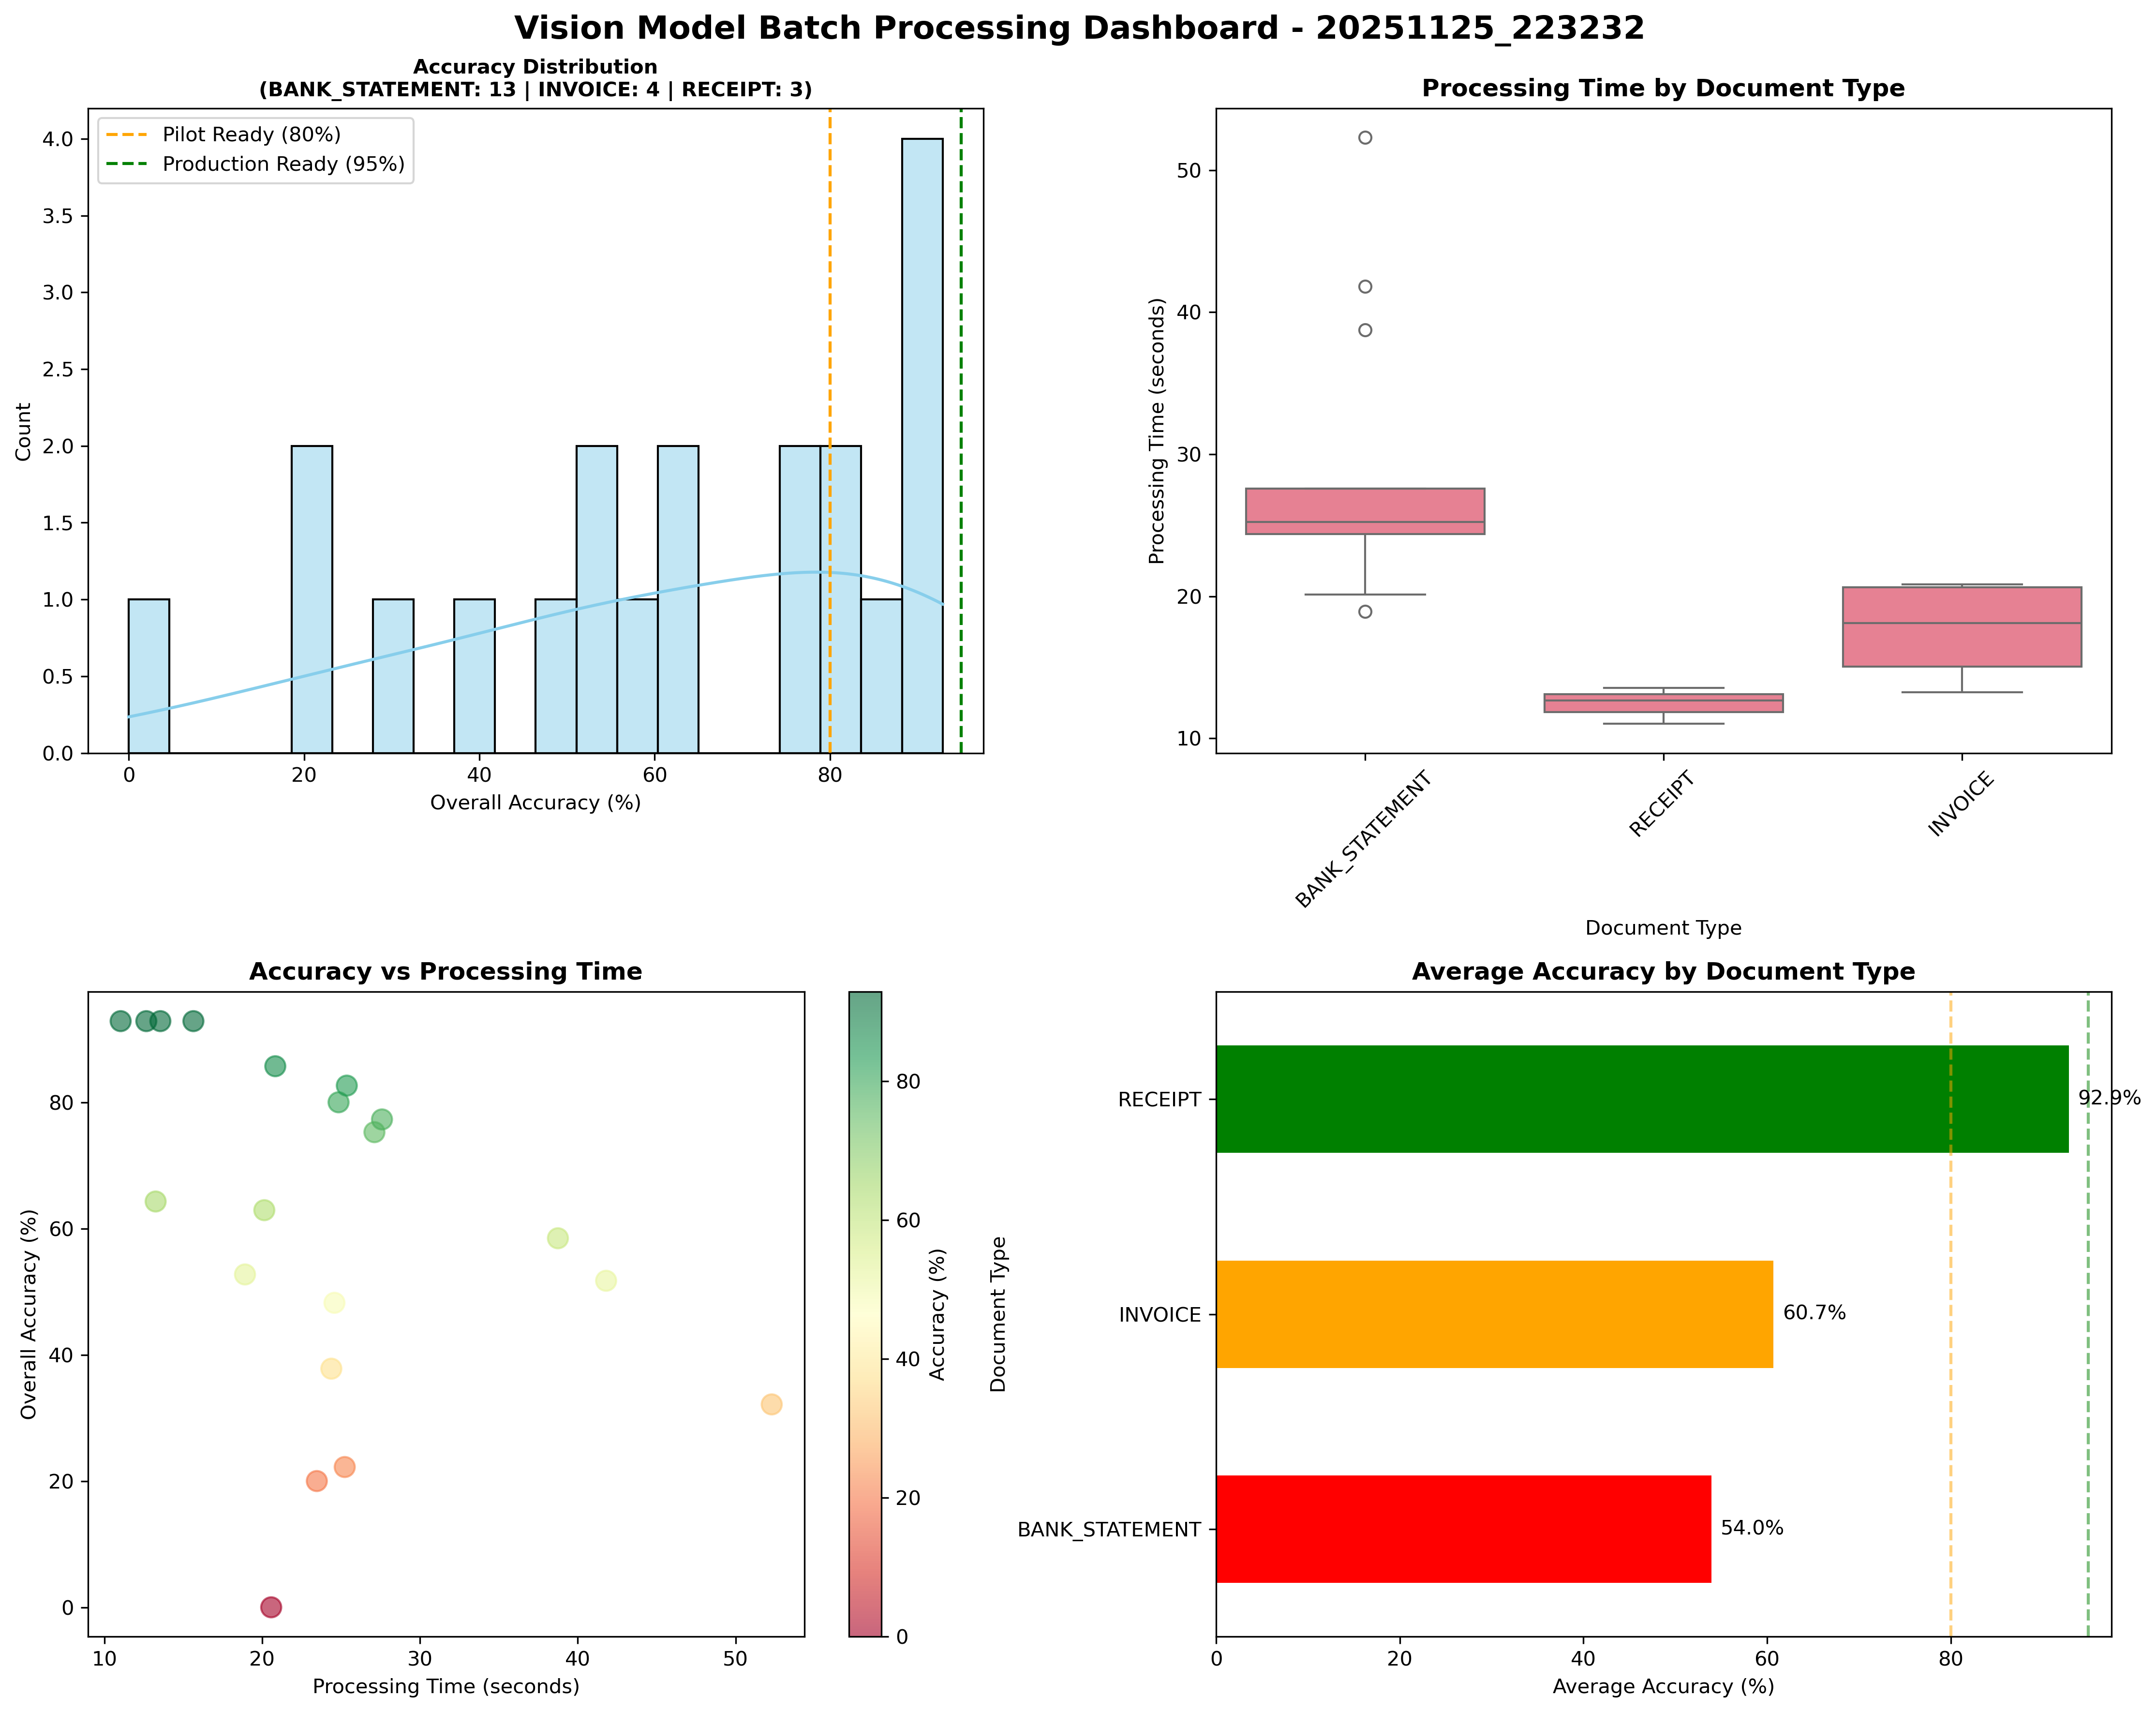

In [13]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [14]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 20

Documents with 0% accuracy: 1

Zero accuracy rate: 5.0%

Documents with 0% Accuracy:

1. image_010.png (INVOICE)

Fields extracted: 0/0